# Load Data

In [1]:
import statsmodels.formula.api as smf
from heterogenity_clusters import get_trade_code_clusters
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("pricing_treatment.csv", parse_dates=["date"])
trade_clusters = get_trade_code_clusters(df, n_clusters=3)

In [2]:
df["date"] = df["date"].dt.tz_localize(None)
cutoff = df["date"].max() - pd.Timedelta(days=60) 
df["treated"] = (df["treatment"] == "treatment").astype(int)
df["post"]    = (df["date"] >= cutoff).astype(int)
df["did"]     = df["treated"] * df["post"]  

# TWFE


1. Fit a regression:

   $$
   Y_{it} = \beta \cdot did_{it} + \alpha_i + \delta_t + \epsilon_{it}
   $$

   where:
   - $\alpha_i$: trade fixed effects (control for time-invariant differences between trades)
   - $\delta_t$: date fixed effects (control for shocks common to all trades on a given day)
   - $did_{it}$: treatment × post indicator

2. Estimate $\beta$ using OLS with cluster-robust standard errors.

### Nature:
A regression formulation of Difference-in-Differences that controls for:
- Trade code-specific baseline differences
- Day-specific differences

### Advantages:
- If you want to also control for something else (e.g., seasonality, holidays, number of searches, competitor price), then simple DiD gets messy very fast and isn’t scalable.
- Can incorporate other covariates easily
- Incorporate different treatment dates
- Works in **multi-period** or **staggered-treatment** settings without rewriting the math


In [3]:
# C(trade_code)  = trade fixed effect  (αᵢ)
# C(date)        = day fixed effect    (δₜ)


mod = smf.ols('bookings ~ did + C(trade_code) + C(date)', data=df)
res = mod.fit(cov_type="cluster", cov_kwds={"groups": df["trade_code"]})

print(res.params["did"])


-28.381233003219414


# DiD

| period | group   | notation | how you get it                                                                 |
| ------ | ------- | -------- | ------------------------------------------------------------------------------ |
| Before | Treated | Yᴮᵉᶠᵗ\_T | mean bookings (or profit, etc.) of treated lanes **before** the switch-on date |
| Before | Control | Yᴮᵉᶠᵗ\_C | mean bookings of control lanes before the switch                               |
| After  | Treated | Yᴬᶠᵗ\_T  | mean bookings of treated lanes **after** the switch                            |
| After  | Control | Yᴬᶠᵗ\_C  | mean bookings of control lanes after the switch                                |


- Change in Treated  =  Yᴬᶠᵗ_T − Yᴮᵉᶠᵗ_T
- Change in Control  =  Yᴬᶠᵗ_C − Yᴮᵉᶠᵗ_C
- ATE  =  (Yᴬᶠᵗ_T − Yᴮᵉᶠᵗ_T)  −  (Yᴬᶠᵗ_C − Yᴮᶠᵗ_C)


In [4]:
g = (df.groupby(["treated", "post"])["bookings"]
       .mean()
       .unstack())          # columns: 0 = Before, 1 = After

ate_bookings = (g.loc[1,1] - g.loc[1,0]) - (g.loc[0,1] - g.loc[0,0])
print(round(ate_bookings, 1))


-28.4


In [5]:
print(g)

post              0           1
treated                        
0        220.361033  234.060109
1        223.481793  208.799636


In [6]:
# check last date 

# Step 1: Get the last date per trade_code
last_dates = df.groupby("trade_code")["date"].max().reset_index()
last_dates.columns = ["trade_code", "last_date"]

# Step 2: Check how many unique last dates there are
unique_last_dates = last_dates["last_date"].nunique()
print(f"\nNumber of unique last dates: {unique_last_dates}")

# Step 3: Show distribution of last dates
print("\nDistribution of last dates per trade_code:")
print(last_dates["last_date"].value_counts().sort_index())

# Step 4: Show min and max last date across all trade_codes
min_date = last_dates["last_date"].min()
max_date = last_dates["last_date"].max()
print(f"\nEarliest last date: {min_date}")
print(f"Latest last date  : {max_date}")
print(f"Difference between earliest and latest last date: {(max_date - min_date).days} days")

# Optional: View full per-trade breakdown
# print(last_dates.sort_values("last_date"))



Number of unique last dates: 1

Distribution of last dates per trade_code:
last_date
2025-06-29    54
Name: count, dtype: int64

Earliest last date: 2025-06-29 00:00:00
Latest last date  : 2025-06-29 00:00:00
Difference between earliest and latest last date: 0 days


# DiD with Clusters

In [7]:
df = pd.read_csv("pricing_treatment.csv", parse_dates=["date"])
df["date"] = df["date"].dt.tz_localize(None)

# Step 1: Get clusters
trade_clusters = get_trade_code_clusters(df, n_clusters=3)
df["cluster"] = df["trade_code"].map(trade_clusters)

# Step 2: DiD variables
cutoff = df["date"].max() - pd.Timedelta(days=60) 
df["treated"] = (df["treatment"] == "treatment").astype(int)
df["post"]    = (df["date"] >= cutoff).astype(int)
df["did"]     = df["treated"] * df["post"]

# Step 3: Estimate DiD per cluster
results = []

for cluster_id in sorted(df["cluster"].unique()):
    df_cluster = df[df["cluster"] == cluster_id]
    
    # Basic group diff method (optional for ATE sanity check)
    g = df_cluster.groupby(["treated", "post"])["bookings"].mean().unstack()
    ate_bookings = (g.loc[1,1] - g.loc[1,0]) - (g.loc[0,1] - g.loc[0,0])
    
    # TWFE model
    mod = smf.ols('bookings ~ did + C(trade_code) + C(date)', data=df_cluster)
    res = mod.fit(cov_type="cluster", cov_kwds={"groups": df_cluster["trade_code"]})
    
    results.append({
        "cluster": cluster_id,
        "n_trades": df_cluster["trade_code"].nunique(),
        "ate_bookings": round(ate_bookings, 2),
        "did_coef": round(res.params["did"], 2),
        "p_value": round(res.pvalues["did"], 4)
    })

# Step 4: Summary
results_df = pd.DataFrame(results)
print(results_df)

   cluster  n_trades  ate_bookings  did_coef  p_value
0        0        32        -20.08    -20.08      0.0
1        1         6        -73.88    -73.88      0.0
2        2        16        -27.93    -27.93      0.0


C:\Users\as26a\AppData\Local\Temp\ipykernel_26000\532307580.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


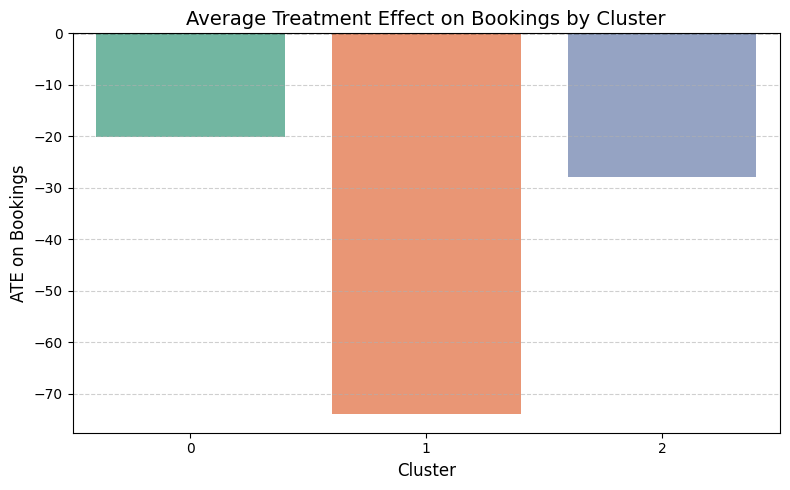

In [8]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=results_df,
    x="cluster",
    y="ate_bookings",
    palette="Set2"
)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Average Treatment Effect on Bookings by Cluster", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("ATE on Bookings", fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# Analysis with time and cluster id

In [ ]:
df = pd.read_csv("pricing_treatment.csv", parse_dates=["date"])
df["date"] = df["date"].dt.tz_localize(None)

# Get clusters
trade_clusters = get_trade_code_clusters(df, n_clusters=3)
df["cluster"] = df["trade_code"].map(trade_clusters)

# Step 2: DiD variables
cutoff = df["date"].max() - pd.Timedelta(days=60) 
df["treated"] = (df["treatment"] == "treatment").astype(int)
df["post"]    = (df["date"] >= cutoff).astype(int)
df["did"]     = df["treated"] * df["post"]

# Estimate DiD per cluster
results = []
time_intervals = [15,30,45,60]
for interval in time_intervals:
    # need to filter the df with the given time interval
    # if the interval is 15 then we take the data from cutoff date + next 15 days
    # if the interval is 60 then we take the data from cutoff date + next 60 days....
    # loop below would work on the filtered data
    date_upper = cutoff + pd.Timedelta(days=interval)
    mask_pre  = df["date"] <  cutoff          # all pre rows
    mask_post = (df["date"] >= cutoff) & (df["date"] <= date_upper)
    df_interval = df[mask_pre | mask_post]

    for cluster_id in sorted(df_interval["cluster"].unique()):
        df_cluster = df_interval[df_interval["cluster"] == cluster_id]
        

        try:
            g = df_cluster.groupby(["treated", "post"])["bookings"].mean().unstack()
            ate_bookings = (g.loc[1,1] - g.loc[1,0]) - (g.loc[0,1] - g.loc[0,0])
        except:
            ate_bookings = float('nan')
        
        # TWFE model
        mod = smf.ols('bookings ~ did + C(trade_code) + C(date)', data=df_cluster)
        res = mod.fit(cov_type="cluster", cov_kwds={"groups": df_cluster["trade_code"]})
        
        results.append({
            "cluster": cluster_id,
            "days_after_cutoff": interval,
            "n_trades": df_cluster["trade_code"].nunique(),
            "ate_bookings": round(ate_bookings, 2),
            "did_coef": round(res.params["did"], 2),
            "p_value": round(res.pvalues["did"], 4)
        })


results_df = pd.DataFrame(results)
results_df = (results_df
              .sort_values(['cluster', 'days_after_cutoff'], ascending=[True, True])
              .reset_index(drop=True))
print(results_df)

    cluster  days_after_cutoff  n_trades  ate_bookings  did_coef  p_value
0         0                 15        32        -16.04    -16.04   0.0071
1         0                 30        32        -18.81    -18.81   0.0003
2         0                 45        32        -17.90    -17.90   0.0001
3         0                 60        32        -20.08    -20.08   0.0000
4         1                 15         6        -36.19    -36.19   0.0437
5         1                 30         6        -60.01    -60.01   0.0000
6         1                 45         6        -75.13    -75.13   0.0000
7         1                 60         6        -73.88    -73.88   0.0000
8         2                 15        16        -21.85    -21.85   0.0145
9         2                 30        16        -32.10    -32.10   0.0000
10        2                 45        16        -26.97    -26.97   0.0002
11        2                 60        16        -27.93    -27.93   0.0000


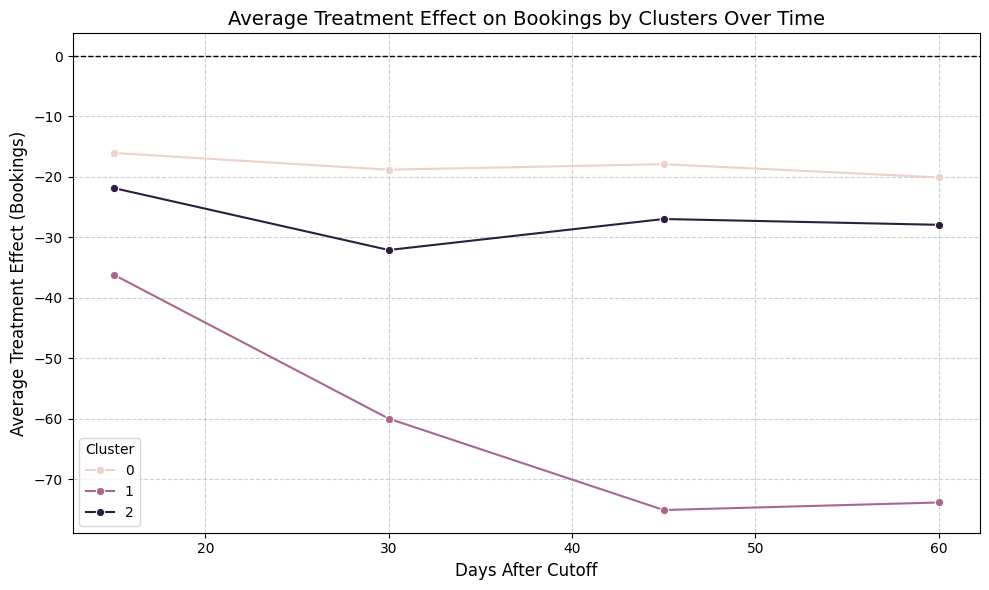

In [10]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=results_df,
    x="days_after_cutoff",
    y="ate_bookings",
    hue="cluster",
    marker="o"
)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Average Treatment Effect on Bookings by Clusters Over Time", fontsize=14)
plt.xlabel("Days After Cutoff", fontsize=12)
plt.ylabel("Average Treatment Effect (Bookings)", fontsize=12)
plt.legend(title="Cluster")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## 📊 Executive Summary – Treatment Effect Analysis (Difference-in-Differences)

The table below shows the estimated treatment effects (change in bookings) for each cluster across different time intervals after the intervention (cutoff). All effects are negative, indicating a reduction in bookings due to the treatment.

| **Cluster** | **Days After Cutoff** | **Δ Bookings (DiD Coefficient)** | **Significance (p-value)** |
|-------------|------------------------|-----------------------------|------------------------|
| 0           | 15 → 60                | −16.04 → −20.08             | All p < 0.01           |
| 1           | 15 → 60                | −36.19 → −73.88             | p ≈ 0.04 → p < 0.001   |
| 2           | 15 → 60                | −21.85 → −27.93             | All p < 0.02           |

---

**Key Finding:**  
Across **all clusters** and **all time intervals**, the price intervention resulted in a **negative treatment effect** on bookings. This means that the intervention consistently reduced the number of bookings regardless of product cluster or time since implementation.

---

### 📌 Results Overview
- **Cluster 0 (32 trade codes):** Persistent decline in bookings (−16 to −20 bookings) across all intervals.  
- **Cluster 1 (6 trade codes):** Severe decline, worsening to over −70 bookings by day 60.  
- **Cluster 2 (16 trade codes):** Significant decline (−22 to −28 bookings) sustained throughout.  
- **Aggregate:** The combined effect across all clusters is **negative** and statistically significant.

---

### 🚨 Recommendation
The data provides **no evidence** of a positive impact in any segment or time period.  
**Immediate action:**  
- **Terminate** the current price intervention across all clusters.  
- **Revert** to the previous pricing strategy or implement a new, evidence-based pricing model.  
- Conduct targeted, smaller-scale price experiments before any future rollout.

---

**Bottom line:** The current intervention is causing sustained booking losses across the board. Continuing it will likely result in further revenue decline.

